# Libraries

In [65]:
%matplotlib inline
import pandas as pd
import numpy as np
import re
import copy
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('classic')

# Data and constants

In [66]:
lts_list = ['0-7', '2-22', '3-22', '6-35', '7-24', '9-21', '11-22', '12-14', '12-26', '13-11', '13-19', '14-27', '15-3', '16-11', '16-22']
df_list = []
df_by_category_list = []

path = '/Users/feliperuiz/Desktop/github/stackage-evolution/notebooks'

for idx, lts in enumerate(lts_list):
    df = pd.read_pickle(f'{path}/lts-{lts}/lts-{lts}.df')
    df_list.append(df)
    
for idx, lts in enumerate(lts_list):
    df = pd.read_pickle(f'{path}/lts-{lts}/lts-{lts}-by-category.df')
    df_by_category_list.append(df)

# RQ0. Distribution

In this section, we respond the following two questions:

- How are packages distributed in stackage?
- How are packages using mtl distributed in Stackage?

For this, we make the following graphs

1. Line graph that shows the number of packets for each published snapshot over time
2. Bar graph that shows the evolution of the main categories of the packages
3. Bar graph that shows the evolution of the stabilities of the packages
4. Bar graph that shows the evolution of the main categories of the packages that depend of `mtl`
5. Bar graph that shows the evolution of the stabilities of the packages that depend of `mtl`

## RQ0. 1 - Line graph that shows the number of packets for each published snapshot over time

In [67]:
from datetime import datetime,timedelta

total_pkgs = []
lts_datetim = [datetime(2014,12,27), datetime(2015,8,9), 
            datetime(2016,1,10), datetime(2017,6,5), 
            datetime(2017,5,28), datetime(2017,12,28), 
            datetime(2018,8,18), datetime(2018,10,21), 
            datetime(2018,12,30), datetime(2019,3,8), 
            datetime(2019,4,29), datetime(2020,2,15), 
            datetime(2020,3,7), datetime(2020,8,25), datetime(2021,1,17)]
lts_date = ["2014-12", "2015-08", "2016-01", "2017-07", "2017-05", "2017-12", 
            "2018-06", "2018-09", "2018-12", "2019-03", "2019-06", "2020-01", 
            "2020-04", "2020-08", "2021-01"]
dates = matplotlib.dates.date2num(lts_date)
for df in df_list:
    total_pkgs.append(len(df))

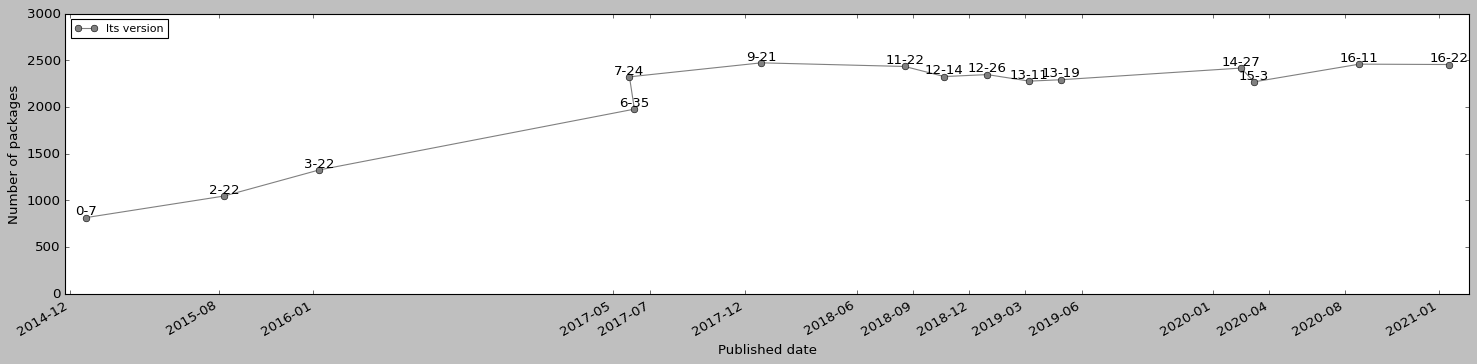

In [68]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

fig, ax = plt.subplots(figsize=(18,5))
ax.margins(0.015) 
plt.subplots_adjust(right=1.1)


#line = ax.plot(dates, total_pkgs, color='grey', marker='o',label='lts version')
plt.plot_date(lts_datetim, total_pkgs, linestyle='solid',color='grey',label='lts version')
plt.gcf().autofmt_xdate()

for i in range(len(lts_list)):
    plt.text(lts_datetim[i],total_pkgs[i],lts_list[i],ha="center",va="bottom")

ax.set_yticks([0,500, 1000, 1500, 2000, 2500, 3000])
ax.set_yticklabels(['0','500', '1000', '1500', '2000', '2500', '3000'])

ax.set_xticks(dates)
ax.set_xticklabels(lts_date)

ax.set_xlabel('Published date')
ax.set_ylabel('Number of packages')
ax.legend(loc='upper left', fontsize='small', bbox_to_anchor=(0, 1))

plt.savefig("graphs/rq0-1.pdf", format='pdf', bbox_inches='tight')
plt.show()

## RQ0. 2 - Bar graph that shows the evolution of the main categories of the packages

In [69]:
from api import create_lts_obj
categories = ['data', 'web', 'control', 'text', 'network']
data = {
    'data': [],
    'web': [],
    'control': [],
    'text': [],
    'network': []
}
count_pkgs = {
    'data': [],
    'web': [],
    'control': [],
    'text': [],
    'network': []
}
df_by_cat = []


for idx, df in enumerate(df_by_category_list):
    aux_df = df[['package', 'category']]
    aux_df = aux_df.groupby(['category']).count().reset_index().rename(columns={"package": "count"})
    aux_df.loc[:, 'version'] = lts_list[idx]
    df_by_cat.append(aux_df.sort_values(by=['count'], ascending=False))
    
for category in categories:
    for idx, lts in enumerate(lts_list):
        total_pkgs = len(df_by_category_list[idx])
        aux = int(df_by_cat[idx][df_by_cat[idx]['category'] == category]['count']) * 100 / total_pkgs   

        count = int(df_by_cat[idx][df_by_cat[idx]['category'] == category]['count'])
        count_pkgs[category].append(count)
        data[category].append(aux)

others = []
per_others = []
for idx, lts in enumerate(lts_list):
    count = 0
    for category in count_pkgs:
        count += count_pkgs[category][idx]
    
    others.append(len(df_by_category_list[idx]) - count)
    per_others.append((len(df_by_category_list[idx]) - count) * 100 / len(df_by_category_list[idx]))

data['others'] = per_others
count_pkgs['others'] = others

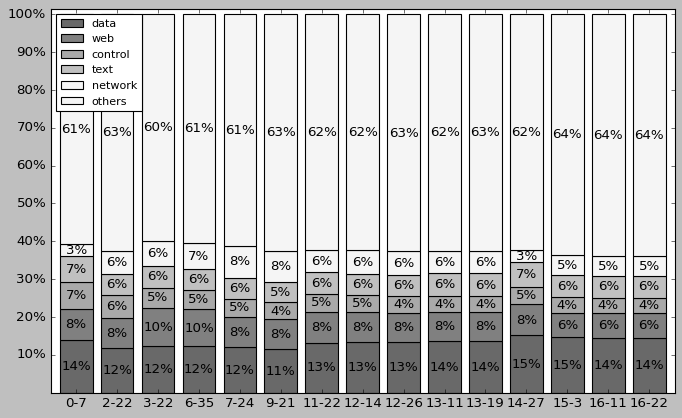

In [70]:
import operator
fig, ax = plt.subplots()
ax.margins(0.015) 
plt.subplots_adjust(right=1.1)

bar1 = ax.bar(x=lts_list, height=data['data'], width=0.8, color='dimgrey', align='center', label='data')
bar2 = ax.bar(x=lts_list, height=data['web'], width=0.8, bottom=data['data'], color='grey', label='web')
bar3 = ax.bar(x=lts_list, height=data['control'], width=0.8, bottom=list(map(operator.add, data['data'], data['web'])), color='darkgrey', label='control')
bar4 = ax.bar(x=lts_list, height=data['text'], width=0.8, bottom=list(map(operator.add, list(map(operator.add, data['data'], data['web'])), data['control'])), color='silver', label='text')
bar5 = ax.bar(x=lts_list, height=data['network'], width=0.8, bottom=list(map(operator.add, list(map(operator.add, list(map(operator.add, data['data'], data['web'])), data['control'])), data['text'])), color='whitesmoke', label='network')
bar6 = ax.bar(x=lts_list, height=data['others'], width=0.8, bottom=list(map(operator.add, list(map(operator.add, list(map(operator.add, list(map(operator.add, data['data'], data['web'])), data['control'])), data['text'])), data['network'])), color='whitesmoke', label='others')

ax.bar_label(bar1, labels=list(map(lambda per: f"{round(per)}%", data['data'])), label_type='center')
ax.bar_label(bar2, labels=list(map(lambda per: f"{round(per)}%", data['web'])), label_type='center')
ax.bar_label(bar3, labels=list(map(lambda per: f"{round(per)}%", data['control'])), label_type='center')
ax.bar_label(bar4, labels=list(map(lambda per: f"{round(per)}%", data['text'])), label_type='center')
ax.bar_label(bar5, labels=list(map(lambda per: f"{round(per)}%", data['network'])), label_type='center')
ax.bar_label(bar6, labels=list(map(lambda per: f"{round(per)}%", data['others'])), label_type='center')


ax.legend(loc='upper left', fontsize='small', bbox_to_anchor=(0, 1))
ax.set_yticks([10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
ax.set_yticklabels(['10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%', '100%'])
plt.savefig("graphs/rq0-2.pdf", format='pdf', bbox_inches='tight')
plt.show()

## RQ0. 3 - Bar graph that shows the evolution of the stabilities of the packages

In [71]:
categories = ['data', 'web', 'control', 'text', 'network']
data = {
    'data': [],
    'web': [],
    'control': [],
    'text': [],
    'network': []
}
count_pkgs = {
    'data': [],
    'web': [],
    'control': [],
    'text': [],
    'network': []
}
df_by_cat = []
for idx, df in enumerate(df_by_category_list):
    aux_df = df[['package', 'category', 'mtl-direct']]
    aux_df = aux_df[aux_df['mtl-direct'] == 1].groupby(['category']).count().reset_index().rename(columns={"package": "count"})   
    aux_df.loc[:, 'version'] = lts_list[idx]
    df_by_cat.append(aux_df.sort_values(by=['count'], ascending=False))

for category in categories:
    for idx, df in enumerate(df_by_category_list):
        total_pkgs = len(df_by_category_list[idx])
        aux = int(df_by_cat[idx][df_by_cat[idx]['category'] == category]['count']) * 100 / total_pkgs   

        count = int(df_by_cat[idx][df_by_cat[idx]['category'] == category]['count']) 
        count_pkgs[category].append(count)
        data[category].append(aux)
others = []
per_others = []
for idx, lts in enumerate(lts_list):
    count = 0
    for category in count_pkgs:
        count += count_pkgs[category][idx]
    
    others.append(len(df_by_category_list[idx]) - count)
    per_others.append((len(df_by_category_list[idx]) - count) * 100 / len(df_by_category_list[idx]))

data['others'] = per_others
count_pkgs['others'] = others


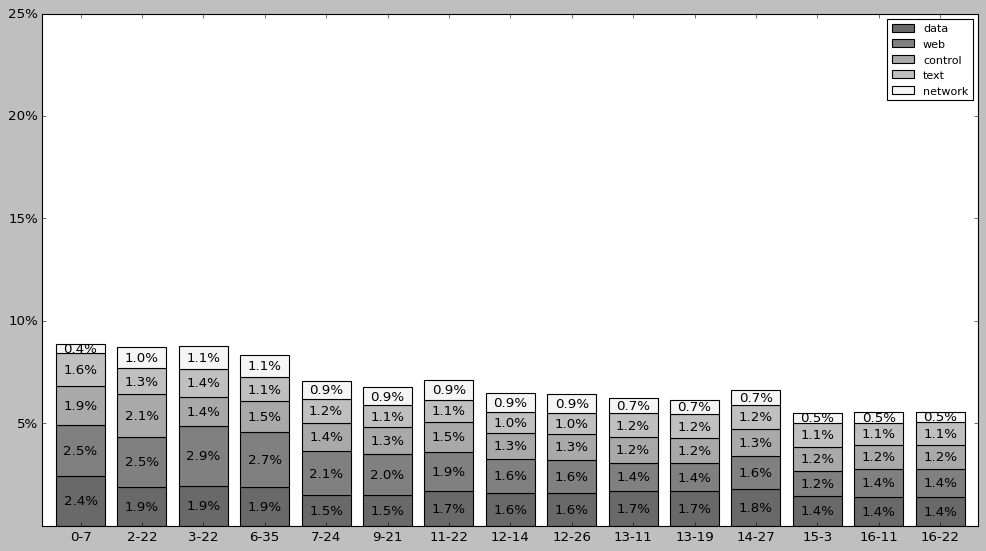

In [72]:
import operator
fig, ax = plt.subplots(figsize=(12,8))
ax.margins(0.015) 
plt.subplots_adjust(right=1.1)

bar1 = ax.bar(x=lts_list, height=data['data'], width=0.8, color='dimgrey', align='center', label='data')
bar2 = ax.bar(x=lts_list, height=data['web'], width=0.8, bottom=data['data'], color='grey', label='web')
bar3 = ax.bar(x=lts_list, height=data['control'], width=0.8, bottom=list(map(operator.add, data['data'], data['web'])), color='darkgrey', label='control')
bar4 = ax.bar(x=lts_list, height=data['text'], width=0.8, bottom=list(map(operator.add, list(map(operator.add, data['data'], data['web'])), data['control'])), color='silver', label='text')
bar5 = ax.bar(x=lts_list, height=data['network'], width=0.8, bottom=list(map(operator.add, list(map(operator.add, list(map(operator.add, data['data'], data['web'])), data['control'])), data['text'])), color='whitesmoke', label='network')

ax.bar_label(bar1, labels=list(map(lambda per: f"{round(per,1)}%", data['data'])), label_type='center')
ax.bar_label(bar2, labels=list(map(lambda per: f"{round(per,1)}%", data['web'])), label_type='center')
ax.bar_label(bar3, labels=list(map(lambda per: f"{round(per,1)}%", data['control'])), label_type='center')
ax.bar_label(bar4, labels=list(map(lambda per: f"{round(per,1)}%", data['text'])), label_type='center')
ax.bar_label(bar5, labels=list(map(lambda per: f"{round(per,1)}%", data['network'])), label_type='center')

ax.legend(loc='upper right', fontsize='small')
ax.set_yticks([5,10, 15, 20, 25])
ax.set_yticklabels(['5%','10%', '15%','20%', '25%'])

plt.savefig("graphs/rq0-3.pdf", format='pdf', bbox_inches='tight')
plt.show()

## RQ0. 4 - Bar graph that shows the evolution of the main categories of the packages that depend of `mtl`

In [73]:
from api import create_lts_obj
stabilities = ['', 'experimental', 'stable', 'provisional', 'alpha', 'beta']
data = {
    '': [],
    'experimental': [],
    'stable': [],
    'provisional': [],
    'alpha': [],
    'beta': []
}
count_pkgs = {
    '': [],
    'experimental': [],
    'stable': [],
    'provisional': [],
    'alpha': [],
    'beta': []
}
stability_df = []

for idx, df in enumerate(df_list):
    aux_df = df[['package', 'stability']]
    aux_df = aux_df.groupby(['stability']).count().reset_index().rename(columns={"package": "count"})
    aux_df.loc[:, 'version'] = lts_list[idx]
    stability_df.append(aux_df.sort_values(by=['count'], ascending=False))

for stability in stabilities:
    for idx, lts in enumerate(df_list):
        total_pkgs = len(df_list[idx])
        
        aux = int(stability_df[idx][stability_df[idx]['stability'] == stability]['count']) * 100 / total_pkgs
        count = int(stability_df[idx][stability_df[idx]['stability'] == stability]['count'])
        count_pkgs[stability].append(count)
        data[stability].append(aux)

stabilities[0]='n/a'
for i in range (len(data['alpha'])):
    data['alpha'][i] = data['alpha'][i]+data['beta'][i]

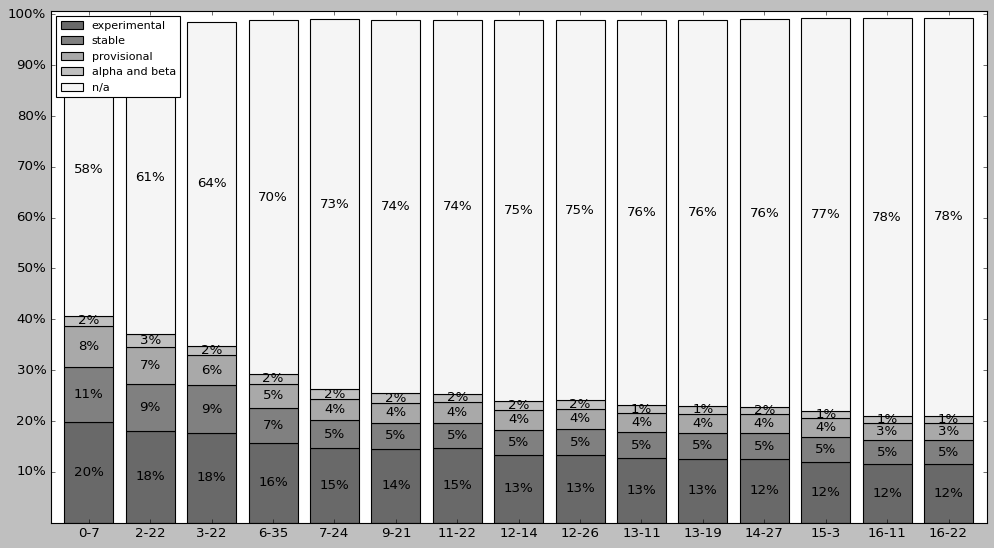

In [74]:
import operator
fig, ax = plt.subplots(figsize=(12,8))
ax.margins(0.015) 
plt.subplots_adjust(right=1.1)

bar1 = ax.bar(x=lts_list, height=data['experimental'], width=0.8, color='dimgrey', align='center', label='experimental')
bar2 = ax.bar(x=lts_list, height=data['stable'], width=0.8, bottom=data['experimental'], color='grey', label='stable')
bar3 = ax.bar(x=lts_list, height=data['provisional'], width=0.8, bottom=list(map(operator.add, data['experimental'], data['stable'])), color='darkgrey', label='provisional')
bar4 = ax.bar(x=lts_list, height=data['alpha'], width=0.8, bottom=list(map(operator.add, list(map(operator.add, data['experimental'], data['stable'])), data['provisional'])), color='silver', label='alpha and beta')
bar5 = ax.bar(x=lts_list, height=data[''], width=0.8, bottom=list(map(operator.add, list(map(operator.add, list(map(operator.add, data['experimental'], data['stable'])), data['provisional'])), data['alpha'])), color='whitesmoke', label='n/a')

ax.bar_label(bar1, labels=list(map(lambda per: f"{round(per)}%", data['experimental'])), label_type='center')
ax.bar_label(bar2, labels=list(map(lambda per: f"{round(per)}%", data['stable'])), label_type='center')
ax.bar_label(bar3, labels=list(map(lambda per: f"{round(per)}%", data['provisional'])), label_type='center')
ax.bar_label(bar4, labels=list(map(lambda per: f"{round(per)}%", data['alpha'])), label_type='center')
ax.bar_label(bar5, labels=list(map(lambda per: f"{round(per)}%", data[''])), label_type='center')

ax.legend(loc='upper left', fontsize='small', bbox_to_anchor=(0, 1))
ax.set_yticks([10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
ax.set_yticklabels(['10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%', '100%'])
plt.savefig("graphs/rq0-4.pdf", format='pdf', bbox_inches='tight')
plt.show()

## RQ0. 5 - Bar graph that shows the evolution of the stabilities of the packages that depend of `mtl`

In [75]:
stabilities = ['', 'experimental', 'stable', 'provisional', 'alpha', 'beta']
data = {
    '': [],
    'experimental': [],
    'stable': [],
    'provisional': [],
    'alpha': [],
    'beta': []
}
count_pkgs = {
    '': [],
    'experimental': [],
    'stable': [],
    'provisional': [],
    'alpha': [],
    'beta': []
}
stability_df = []

for idx, df in enumerate(df_list):
    aux_df = df[['package', 'stability', 'mtl-direct']]
    aux_df = aux_df[aux_df['mtl-direct'] == 1].groupby(['stability']).count().reset_index().rename(columns={"package": "count"})
    aux_df.loc[:, 'version'] = lts_list[idx]
    stability_df.append(aux_df.sort_values(by=['count'], ascending=False))

for stability in stabilities:
    for idx, lts in enumerate(df_list):
        total_pkgs = len(df_list[idx])
        
        aux = int(stability_df[idx][stability_df[idx]['stability'] == stability]['count']) * 100 / total_pkgs
        count = int(stability_df[idx][stability_df[idx]['stability'] == stability]['count'])
        count_pkgs[stability].append(count)
        data[stability].append(aux)
        
stabilities[0]='n/a'
for i in range (len(data['alpha'])):
    data['alpha'][i] = data['alpha'][i]+data['beta'][i]

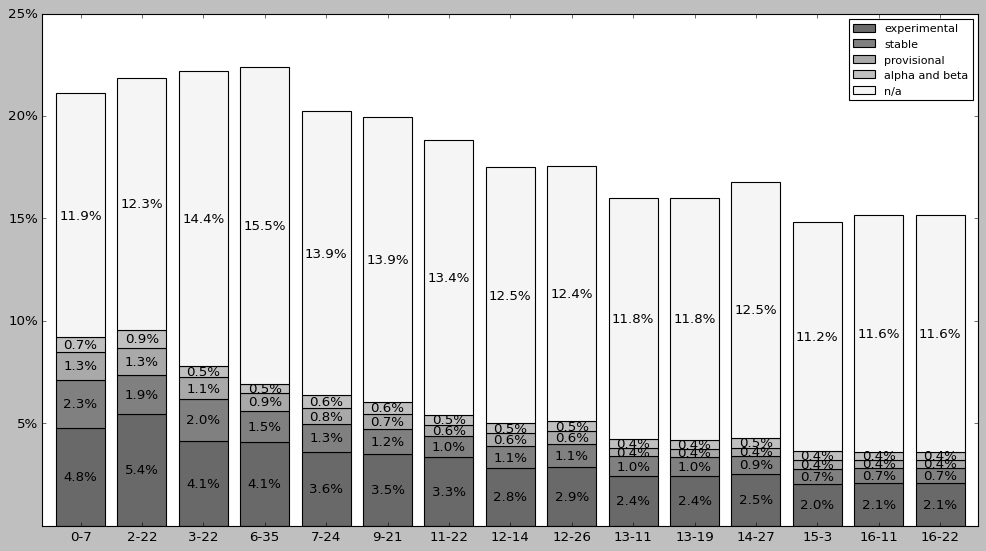

In [76]:
fig, ax = plt.subplots(figsize=(12,8))
ax.margins(0.015) 
plt.subplots_adjust(right=1.1)

bar1 = ax.bar(x=lts_list, height=data['experimental'], width=0.8, color='dimgrey', align='center', label='experimental')
bar2 = ax.bar(x=lts_list, height=data['stable'], width=0.8, bottom=data['experimental'], color='grey', label='stable')
bar3 = ax.bar(x=lts_list, height=data['provisional'], width=0.8, bottom=list(map(operator.add, data['experimental'], data['stable'])), color='darkgrey', label='provisional')
bar4 = ax.bar(x=lts_list, height=data['alpha'], width=0.8, bottom=list(map(operator.add, list(map(operator.add, data['experimental'], data['stable'])), data['provisional'])), color='silver', label='alpha and beta')
bar5 = ax.bar(x=lts_list, height=data[''], width=0.8, bottom=list(map(operator.add, list(map(operator.add, list(map(operator.add, data['experimental'], data['stable'])), data['provisional'])), data['alpha'])), color='whitesmoke', label='n/a')

ax.bar_label(bar1, labels=list(map(lambda per: f"{round(per,1)}%", data['experimental'])), label_type='center')
ax.bar_label(bar2, labels=list(map(lambda per: f"{round(per,1)}%", data['stable'])), label_type='center')
ax.bar_label(bar3, labels=list(map(lambda per: f"{round(per,1)}%", data['provisional'])), label_type='center')
ax.bar_label(bar4, labels=list(map(lambda per: f"{round(per,1)}%", data['alpha'])), label_type='center')
ax.bar_label(bar5, labels=list(map(lambda per: f"{round(per,1)}%", data[''])), label_type='center')

ax.legend(loc='upper right', fontsize='small')
ax.set_yticks([5,10, 15, 20, 25])
ax.set_yticklabels(['5%','10%', '15%','20%', '25%'])
plt.savefig("graphs/rq0-5.pdf", format='pdf', bbox_inches='tight')
plt.show()

# Research Questions (RQs)

- **RQ 1.** What packages are the most used? Which of them are outside from the Stackage selection?
- **RQ 2.** How many dependencies of packages are outside from the Stackage selection (in)directly?
- **RQ 3.** How frequently are the packages updated? 

Regarding monads, we analyze the evolution of dependencies of monad modules available in the mtl package:

- **RQ 4.** How has the use of monads evolved?
- **RQ 5.** Are there packages that stopped using monads?


## RQ 1. What packages are the most used? Which of them are outside from the Stackage selection?

Consideramos el ultimo snapshot publicado en Stackage, especificamente el LTS 16.11. Utilizamos el campo **Dependencies** del DataFrame para obtener el listado de las dependencias de cada paquete y construimos un diccionario de todos los paquetes y sus dependencias. Contamos la cantidad de veces que fue requerido cada uno de ellos para posteriormente ordenarlos ascendentemente y filtrar el top 25 de los mas utilizados. Luego, restamos el conjunto de todos los paquetes seleccionados del LTS 16.11 a la lista de los top 25 mas utilizados para obtener los paquetes que no formaron parte de la seleccion.

In [77]:
from api import get_pkgs_usage_count
top_25_pkgs = []
top_25_count = []
top_25_list = dict()

for idx, lts in enumerate(lts_list):
    top_25 = dict()
    packet_usage_count = get_pkgs_usage_count(df_list[idx])
    ordered_pkgs = sorted(packet_usage_count, key=packet_usage_count.get, reverse=True)[:25]

    for pkg in ordered_pkgs:
        top_25_pkgs.append(pkg)
        top_25_count.append(packet_usage_count[pkg])
        top_25[pkg] = packet_usage_count[pkg]
    
    top_25_list[lts] = top_25 

### Se encarga de generar el codigo de latex del top 10 de archivos

In [78]:
top = 6
latex = ''
list_lts_top25 = []
for lts in lts_list:
    list_top25 = list(top_25_list[lts].keys())
    list_lts_top25.append(list_top25)

for j in range(5,16):
    for i in range(len(list_lts_top25)-1):
        if i == 0:
            latex = latex + 'Top '+str(top)+' & '+list_lts_top25[i][j] + ' & '
        elif i == len(list_lts_top25)-2:
            latex = latex + list_lts_top25[i][j] + '\\\ \n'
        else:
            latex = latex + list_lts_top25[i][j] + ' & '
    top += 1

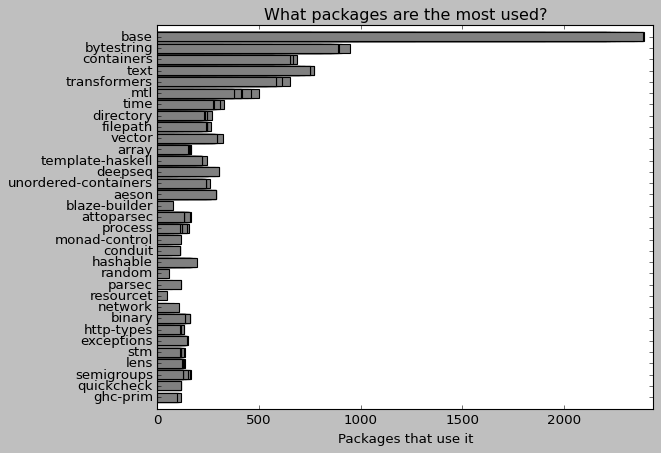

In [79]:
# Sacar base si es qe todos utilizan base por definicion.

fig, ax = plt.subplots()
ax.margins(0.02)   
hbars = ax.barh(top_25_pkgs, top_25_count, align='center', color='grey')
ax.invert_yaxis() 
ax.set_xlabel('Packages that use it')
ax.set_title('What packages are the most used?')
plt.show()

In [80]:
from api import get_pkgs_usage_count, get_packages_out_of_stackage
pkgs_usage_count = get_pkgs_usage_count(df_list[14])
top = sorted(pkgs_usage_count, key=pkgs_usage_count.get, reverse=True)[:100]
get_packages_out_of_stackage(top, df_list[14])

['quickcheck', 'microlens', 'hunit', 'cabal', 'ghc']

## **RQ 2.** How many packages are outside of Stackage due to his (in)direct dependencies?

Procesamos todos los snapshots que consideramos en nuestra investigacion. Realizamos una busqueda en profundidad a las dependencias de cada paquete de los LTS, buscando alguna dependencia (in)directa que no se encontrara en la seleccion. Si este era el caso, se agregaba a un conjunto de paquetes que luego contabilizamos por cada LTS. Finalmente, calculamos el porcentage que estos paquetes representaban en cada snapshot. 


In [81]:
from api import get_pkgs_out_transitively
out_transitive_pkgs = get_pkgs_out_transitively(df_list)

0-7 processed
2-22 processed
3-22 processed
6-35 processed
7-24 processed
9-21 processed
11-22 processed
12-14 processed
12-26 processed
13-11 processed
13-19 processed
14-27 processed
15-3 processed
16-11 processed
16-22 processed


In [82]:
count_transitive = {}
per_transitive = {}
diff_transitive = {}  
diff_per_transitive = {} 

for idx, lts in enumerate(out_transitive_pkgs):
    count_transitive[lts] = out_transitive_pkgs[lts]
    per_transitive[lts] = round(out_transitive_pkgs[lts]*100 / len(df_list[idx]), 1)
    diff_transitive[lts] = len(df_list[idx]) - out_transitive_pkgs[lts]
    diff_per_transitive[lts] = 100 - per_transitive[lts]
    
index = list(per_transitive.keys())
count_values = list(count_transitive.values())
per_values = list(per_transitive.values())
diff_values = list(diff_transitive.values())
diff_per_values = list(diff_per_transitive.values())

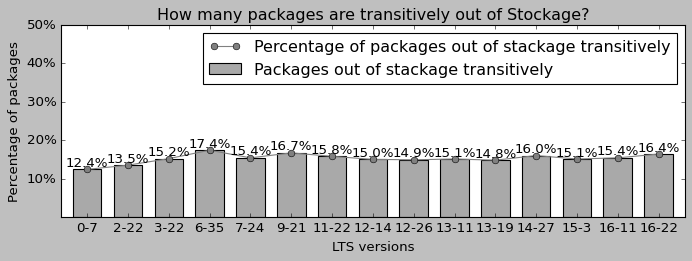

In [83]:
ax = plt.gca()
ax.margins(0.02)    
plt.subplots_adjust(bottom=0.1, right=1.1, top=0.5)
bar = ax.bar(index, per_values, width=0.7, color='darkgrey', align='center', label='Packages out of stackage transitively')
line = ax.plot(index, per_values, color='grey', marker='o', label='Percentage of packages out of stackage transitively')
ax.legend(loc='best')
ax.set_xlabel('LTS versions')
ax.set_ylabel('Percentage of packages')
ax.set_title('How many packages are transitively out of Stockage?')
ax.set_yticks([10, 20, 30, 40, 50])
ax.set_yticklabels(['10%', '20%', '30%', '40%', '50%'])
ax.bar_label(bar, labels=list(map(lambda per: f"{per}%", per_values)))
plt.show()

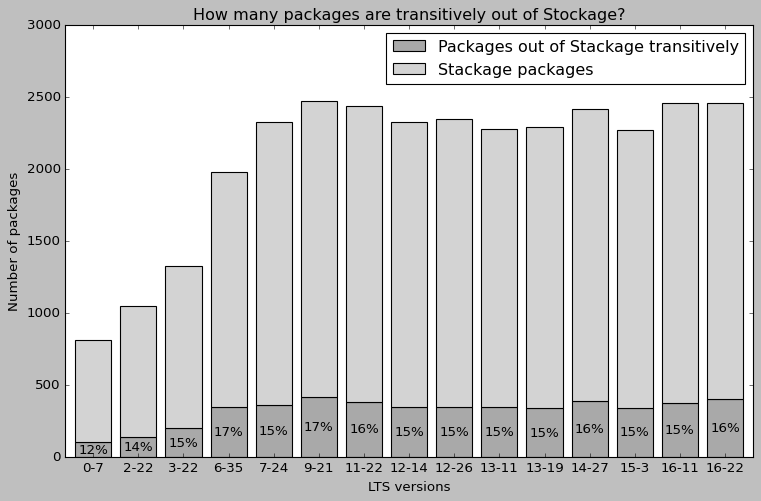

In [84]:
fig, ax = plt.subplots()
ax.margins(0.015) 
plt.subplots_adjust(bottom=0.1, right=1.2, top=1)
bar1 = ax.bar(x=index, height=count_values, width=0.8, color='darkgrey', align='center', label='Packages out of Stackage transitively')
bar2 = ax.bar(index, diff_values, width=0.8, bottom=count_values, color='lightgrey', label='Stackage packages')
ax.legend(loc='best')
ax.set_xlabel('LTS versions')
ax.set_ylabel('Number of packages')
ax.set_title('How many packages are transitively out of Stockage?')
ax.set_yticks([0, 500, 1000, 1500, 2000, 2500, 3000])
ax.bar_label(bar1, labels=list(map(lambda per: f"{round(per)}%", per_values)), label_type='center')
plt.savefig("graphs/rq2.pdf", format='pdf', bbox_inches='tight')
plt.show()

In [85]:
import statistics
mean = statistics.mean(list(per_transitive.values()))
print(f'average over time {mean:.1f}%')

average over time 15.3%


## RQ 3. How frequently are the packages updated? 

Construimos un nuevo DafaFrame que nos muestra la version de cada paquete en cada LTS que llamamos `versions_df`. Procesamos este DataFrame contando la cantidad de veces en que cada paquete actualizo su version a lo largo del tiempo. Luego, calculamos el porcentaje de paquetes que actualizo su version en cada LTS respecto a la cantidad de paquetes totales en el snapshot anterior.

In [86]:
from api import get_versions_df, get_update_count_df, get_count_updated_packages_by_lts
versions_df = get_versions_df(df_list)

In [87]:
update_count_df = get_update_count_df(df_list, versions_df)

In [88]:
count_updated_packages_by_lts = get_count_updated_packages_by_lts(df_list, update_count_df)

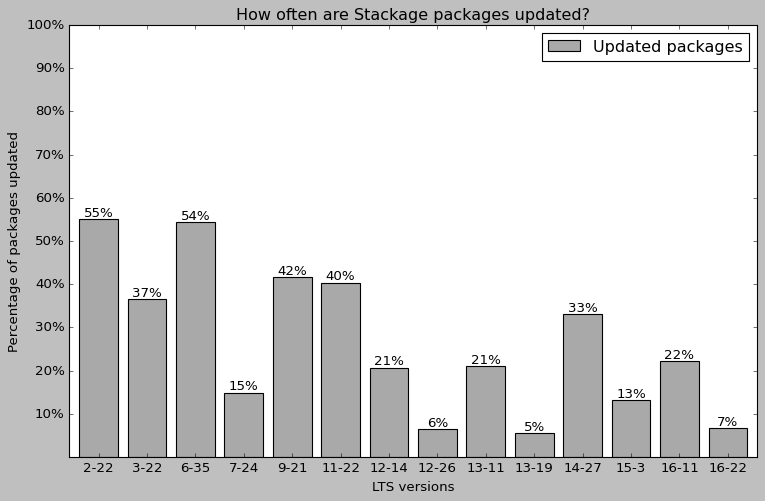

In [89]:
index = list(count_updated_packages_by_lts.keys())
updated_packages = list(count_updated_packages_by_lts.values())

fig, ax = plt.subplots()
ax.margins(0.015) 
plt.subplots_adjust(bottom=0.1, right=1.2, top=1)

bar1 = ax.bar(index, updated_packages, width=0.8, color='darkgrey', align='center', label='Updated packages')
ax.bar_label(bar1, labels=list(map(lambda per: f"{round(per)}%", updated_packages)))

ax.legend(loc='best')
ax.set_xlabel('LTS versions')
ax.set_ylabel('Percentage of packages updated')
ax.set_title('How often are Stackage packages updated?')
ax.set_yticks([10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
ax.set_yticklabels(['10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%', '100%'])
plt.savefig("graphs/rq3.pdf", format='pdf', bbox_inches='tight')
plt.show()

## RQ 4. How has the use of monads evolved?



In [90]:
from api import compute_monad_usage_by_df, create_lts_obj
monads_used = [0, 1, 2, 3, 4, 5, 6, 7, 8]
data = create_lts_obj()
monads_used_df = []

for idx, df in enumerate(df_list):
    df = df[df['mtl-direct'] == 1]
    df = compute_monad_usage_by_df(df)
    aux_df = df[['MonadsUsed', 'package']]
    aux_df = aux_df.groupby(['MonadsUsed']).count().reset_index().rename(columns={'package': 'count'})
    monads_used_df.append(aux_df)

/usr/local/lib/python3.9/site-packages/pandas/core/indexing.py:1598: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
/usr/local/lib/python3.9/site-packages/pandas/core/indexing.py:1675: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [91]:
from api import compute_monad_usage_by_df, create_lts_obj
monads_type = ['State', 'Reader', 'Trans', 'Writer', 'Error', 'Except', 'Identity', 'RWS', 'Continuation', 'List']
monads_type_df_list = []
data = [[], [], [], [], [], [], [], [], [], []]
 
for idx, df in enumerate(df_list):
    mtl_df = df[df['mtl-direct'] == 1]
    mtl_df = compute_monad_usage_by_df(mtl_df)
    monad_type_series = mtl_df[monads_type].sum().sort_values()
    monad_type_df = pd.DataFrame({ "type": monad_type_series.index, "count": monad_type_series.values })
    monads_type_df_list.append(monad_type_df)
    

for num, monad in enumerate(monads_type):    
    for idx, lts in enumerate(lts_list):
        aux = int(monads_type_df_list[idx][monads_type_df_list[idx]['type'] == monad]['count'])
        sum = monads_type_df_list[idx].sum().values[1]
        per = aux * 100 / sum
        data[num].append(per)

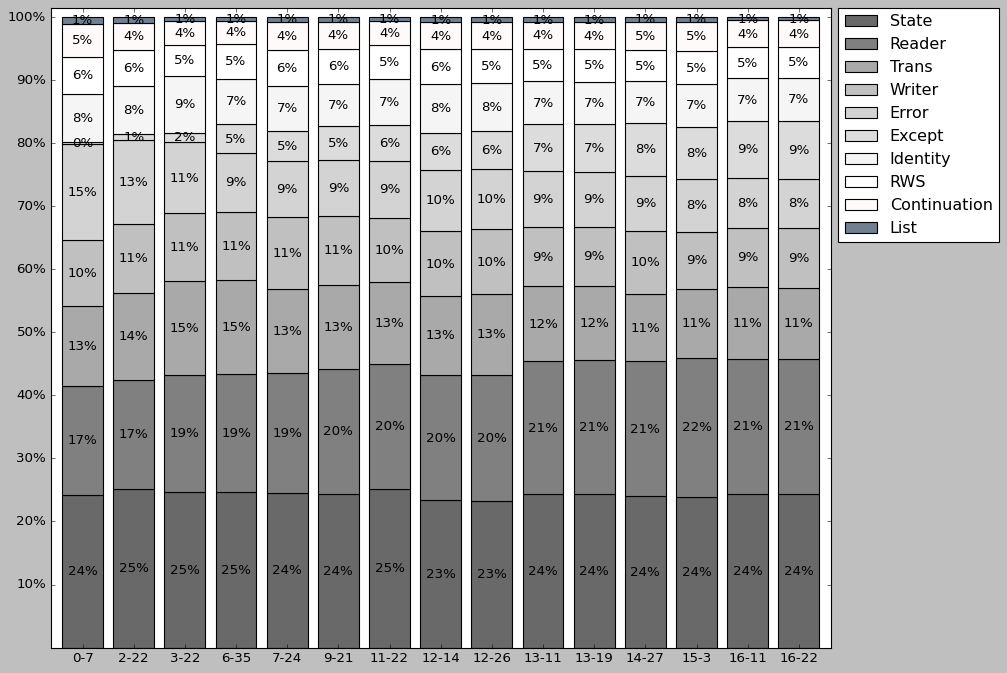

In [92]:
import operator
fig, ax = plt.subplots(figsize=(10, 10))
ax.margins(0.015) 
plt.subplots_adjust(right=1.1)

def calculate_bottom(data, bar_idx):
    if bar_idx == 0:
        return 0
    
    cumsum = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    for idx in range(0, bar_idx):
        cumsum = list(map(operator.add, cumsum, data[idx]))
    
    return cumsum

monads_type = ['State', 'Reader', 'Trans', 'Writer', 'Error', 'Except', 'Identity', 'RWS', 'Continuation', 'List']
colors = colors = ['dimgrey', 'grey', 'darkgrey', 'silver', 'lightgrey', 'gainsboro', 'whitesmoke', 'white', 'snow', 'slategrey']
for idx, monad in enumerate(monads_type):
    bar = ax.bar(x=lts_list, height=data[idx], bottom=calculate_bottom(data, idx), width=.8, color=colors[idx], align='center', label=monad)
    ax.bar_label(bar, labels=list(map(lambda per: f"{round(per)}%", data[idx])), label_type='center', color='black')
    
ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0.)
ax.set_yticks([10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
ax.set_yticklabels(['10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%', '100%'])
plt.savefig("graphs/rq4.pdf", format='pdf', bbox_inches='tight')
plt.show()

## RQ 5.  How many packages that depend of mtl were removed? Are there packages that stopped using monads ?

In [93]:
from api import get_all_time_packages, build_mtl_continuity_matrix
mtl_continuity_df = build_mtl_continuity_matrix(df_list, get_all_time_packages(df_list))

In [122]:
from api import get_added_packages_mtl_by_lts, get_removed_packages_mtl_by_lts
added_mtl_pkgs_count = get_added_packages_mtl_by_lts(mtl_continuity_df)
removed_mtl_pkgs_count = get_removed_packages_mtl_by_lts(mtl_continuity_df)

added_mtl_pkgs_per = [x * 100 / len(df_list[idx]) for idx, x in enumerate(added_mtl_pkgs_count)]
removed_mtl_pkgs_per = [x * 100 / len(df_list[idx]) for idx, x in enumerate(removed_mtl_pkgs_count)]
total = [(x - y) * 100 / len(df_list[idx]) for idx, (x, y) in enumerate(zip(added_mtl_pkgs_count, removed_mtl_pkgs_count))]

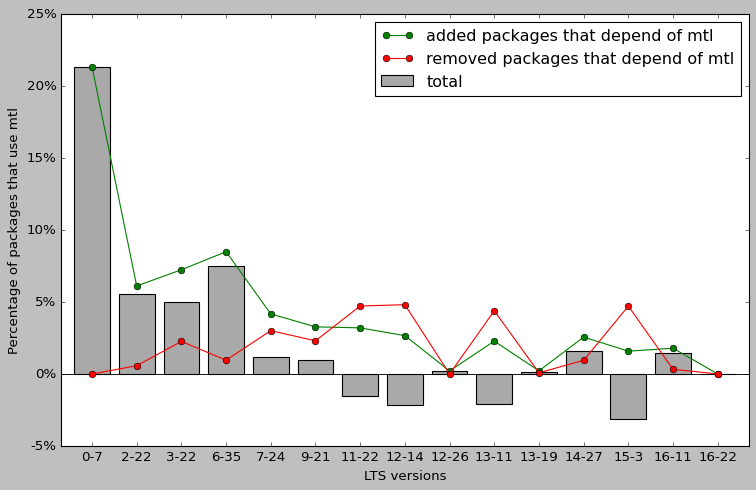

In [127]:
fig, ax = plt.subplots()
ax.margins(0.02) 
plt.subplots_adjust(bottom=0.1, right=1.2, top=1)
ax.axhline(0, color='black', linewidth=0.8)

bar1 = ax.bar(lts_list, total, width=0.8, color='darkgrey', align='center', label='total')
line = ax.plot(lts_list, added_mtl_pkgs_per, color='green', marker='o', label='added packages that depend of mtl ')
line = ax.plot(lts_list, removed_mtl_pkgs_per, color='red', marker='o', label='removed packages that depend of mtl')

ax.legend(loc='best')
ax.set_xlabel('LTS versions')
ax.set_ylabel('Percentage of packages that use mtl')
ax.set_yticks([-5, 0, 5, 10, 15, 20, 25])
ax.set_yticklabels(['-5%', '0%', '5%', '10%', '15%', '20%', '25%'])
plt.show()

### 8. ¿Que paquetes que ya usaban monadas en sus futuras versiones dejaron de usarlas? (en porcentaje (en categoria) y ) ¿en cada version cuantas dejaron de utilzar mtl?)

- Nacieron usando mtl y dejaron de usar mtl pero se mantuvieron en la selección
- Nacieron sin usar mtl y comenzaron a utilizar mtl en el futuro

## Draft

In [ ]:
from api import create_lts_obj
per_mtl_pkgs = create_lts_obj()
for idx, df in enumerate(df_list):
    percentage = len(df[df['mtl-direct'] == 1]) * 100 / len(df)
    per_mtl_pkgs[lts_list[idx]] = percentage
    
index = list(per_mtl_pkgs.keys())
mtl_pkgs = list(per_mtl_pkgs.values())

fig, ax = plt.subplots(())
ax.margins(0.015) 
plt.subplots_adjust(right=1.1)
bar1 = ax.bar(index, mtl_pkgs, width=0.8, color='darkgrey', align='center', label='Updated packages')
ax.bar_label(bar1, labels=list(map(lambda per: f"{round(per)}%", mtl_pkgs)))
ax.legend(loc='best')
ax.set_xlabel('LTS versions')
ax.set_ylabel('Percentage of packages that use mtl')
ax.set_title('What percentage of packages of Stackage use mtl over time?')
ax.set_yticks([10, 20, 30, 40, 50])
ax.set_yticklabels(['10%', '20%', '30%', '40%', '50%'])

import statistics
mean = statistics.mean(list(per_mtl_pkgs.values()))
print(f'average over time {mean:.1f}%')

plt.show()